# Echoes of Change: Analyzing Social Media Sentiment on Climate Action
Akshat Tirumalai  
July 24, 2024

# Introduction

### Overview

This project aims to explore the collective sentiment towards climate change and efforts to save the planet by analyzing tweets over several years. By leveraging sentiment analysis techniques, this study seeks to uncover trends in public opinion and how these sentiments have evolved over time.

### Research Topic and Question

The central research question driving this project is: **"How has public sentiment towards climate action evolved over time, as expressed through social media?"** To address this question, the study focuses on the analysis of tweets, evaluating the positive, negative, and neutral sentiments expressed in relation to climate change and environmental conservation efforts.

### Motivation

The motivation behind this study stems from the growing urgency to address climate change and the crucial role that public opinion plays in shaping policy and driving action. Understanding how people feel about climate action can provide valuable insights for policymakers, activists, and organizations working towards environmental sustainability. Social media, being a widespread platform for public expression, serves as a rich data source to gauge these sentiments.

### Prior Related Work

Previous studies have utilized sentiment analysis on social media data to track public opinion on various topics, including political events, product reviews, and health issues. Specifically, in the realm of climate change, research has shown how social media can reflect public awareness and engagement with environmental issues. This project builds on such foundational work by focusing on a temporal analysis of climate sentiment, providing a detailed view of how opinions have shifted over the years.

By analyzing a large dataset of tweets, this project aims to contribute to the understanding of public sentiment dynamics in the context of climate action, offering a nuanced perspective on the collective mood and its implications for future initiatives to combat climate change.

###  Source & Documentation About the Data
The dataset and its documentation can be accessed here: https://www.kaggle.com/datasets/thedevastator/social-media-sentiment-and-climate-change?select=nltk_split.csv

# Methods

### Importing and Organizing the Data

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from IPython.display import display
import networkx as nx
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from datetime import datetime
import numpy as np

In [2]:
# Ensure necessary NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

I now obtain some more information about this dataset:

In [3]:
# Load the dataset
file_path = 'Dataset.csv'
data = pd.read_csv(file_path)

# Display the info of the dataset
data.head()

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,id,text,favorite_count,retweet_count,created_at,coordinates
0,0,0.0,0.0,0.0,0.0,1028954403129184256,Gotta love the facts. https://t.co/bZ2G8AZuo9,0,0,2018-08-13 10:40:21+00:00,NaN
1,1,1.0,1.0,1.0,1.0,1028954356572250112,RT @ToolangiForest: A great day of action for ...,0,35,2018-08-13 10:40:10+00:00,NaN
2,2,2.0,2.0,2.0,2.0,1028954497341480960,@jonkudelka Harvey Norman reckons climate chan...,2,0,2018-08-13 10:40:43+00:00,NaN
3,3,3.0,3.0,3.0,3.0,1028954494133043200,RT @jayrosen_nyu: Why does skepticism about im...,0,52,2018-08-13 10:40:43+00:00,NaN
4,4,4.0,4.0,4.0,4.0,1028954811511844864,RT @FranceinIreland: On 5th November we call a...,0,16,2018-08-13 10:41:58+00:00,NaN


The dataset contains various columns, some of which are named and others unnamed. The unnamed columns (Unnamed: 0.4, Unnamed: 0.3, Unnamed: 0.2, Unnamed: 0.1, Unnamed: 0) seem to be redundant as they merely represent index-like data and have consistent values corresponding to their row numbers. The key columns of interest are id, text, favorite_count, retweet_count, created_at, and coordinates. The id column provides unique identifiers for each tweet. The text column contains the actual content of the tweets, which is crucial for sentiment analysis. The favorite_count and retweet_count columns indicate the popularity and reach of the tweets, respectively. The created_at column provides the timestamp of when each tweet was posted, which is essential for temporal analysis. Lastly, the coordinates column contains geographic information, although it has a significant number of missing values, which may limit its usefulness.

With this information, the next step involves cleaning the dataset by removing the redundant unnamed columns and handling the missing values in the coordinates column. The relevant columns (id, text, favorite_count, retweet_count, and created_at) will be retained and preprocessed for sentiment analysis and trend exploration. 

In [4]:
# Drop unnecessary columns
data = data[['id', 'text', 'favorite_count', 'retweet_count', 'created_at']]
# Handle missing values
data.dropna(subset=['text'], inplace=True)
# Remove duplicates
data.drop_duplicates(subset='text', inplace=True)

# Display the cleaned data
data.head()

,id,text,favorite_count,retweet_count,created_at
0,1028954403129184256,Gotta love the facts. https://t.co/bZ2G8AZuo9,0,0,2018-08-13 10:40:21+00:00
1,1028954356572250112,RT @ToolangiForest: A great day of action for ...,0,35,2018-08-13 10:40:10+00:00
2,1028954497341480960,@jonkudelka Harvey Norman reckons climate chan...,2,0,2018-08-13 10:40:43+00:00
3,1028954494133043200,RT @jayrosen_nyu: Why does skepticism about im...,0,52,2018-08-13 10:40:43+00:00
4,1028954811511844864,RT @FranceinIreland: On 5th November we call a...,0,16,2018-08-13 10:41:58+00:00


Now, the text data will undergo preprocessing to prepare it for further analysis. I will define a preprocess_text function and apply it to the text column of the dataset. This function should perform the following steps:

1. Remove URLs: Using the regular expression re.sub(r'http\S+', '', text), URLs are removed from the text. This is important as URLs do not contribute to sentiment analysis.

2. Remove Punctuation: The regular expression re.sub(r'[^\w\s]', '', text) is used to strip out punctuation marks, leaving only alphanumeric characters and spaces.

3. Convert to Lowercase: text.lower() is used to convert all characters in the text to lowercase, ensuring uniformity in text analysis.

4. Remove 'rt': The expression re.sub(r'\brt\b', '', text) removes the 'rt' (retweet) term, which is common in retweets but irrelevant for sentiment analysis.


Additionally, the created_at column, which originally contains the full timestamp, will be modified to retain only the year. This will be done to make it easier to analyze trends over time.

In [5]:
# Preprocess text: remove URLs, punctuation, and convert to lowercase
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\brt\b', '', text)  # Remove 'rt'
    return text

data['clean_text'] = data['text'].apply(preprocess_text)

# Modify created_at column to just contain the year
data['created_at'] = pd.to_datetime(data['created_at']).dt.year

data.head()

,id,text,favorite_count,retweet_count,created_at,clean_text
0,1028954403129184256,Gotta love the facts. https://t.co/bZ2G8AZuo9,0,0,2018,gotta love the facts
1,1028954356572250112,RT @ToolangiForest: A great day of action for ...,0,35,2018,toolangiforest a great day of action for our ...
2,1028954497341480960,@jonkudelka Harvey Norman reckons climate chan...,2,0,2018,jonkudelka harvey norman reckons climate chang...
3,1028954494133043200,RT @jayrosen_nyu: Why does skepticism about im...,0,52,2018,jayrosen_nyu why does skepticism about immigr...
4,1028954811511844864,RT @FranceinIreland: On 5th November we call a...,0,16,2018,franceinireland on 5th november we call all c...


Next, I will focus on tokenizing the cleaned text data. The clean_text column will be tokenized using the word_tokenize function, breaking down each text entry into individual words or tokens. Tokenization is essential because it transforms the text into smaller, manageable units that can be easily analyzed and processed for sentiment analysis.

After tokenization, I will remove common stopwords using a predefined list of English stopwords from the NLTK library. Stopwords are common words such as 'and', 'the', and 'is' that do not carry significant meaning and can clutter the analysis. By removing these, I will ensure that the focus remains on the more meaningful words in each tweet, which will improve the accuracy and relevance of the sentiment analysis.

Following the removal of stopwords, I will normalize the tokens through lemmatization. A WordNetLemmatizer will be utilized to convert tokens to their base or root forms, ensuring consistency in the data. For example, words like 'running' and 'ran' will be converted to their root form 'run'. This step is crucial because it reduces the variability in the text data, allowing for more accurate sentiment classification and trend analysis by treating different forms of a word as a single item.

This process will prepare the text data for more detailed sentiment analysis and trend exploration in the subsequent steps.

In [6]:
# Tokenization
data['tokens'] = data['clean_text'].apply(word_tokenize)

# Remove stopwords
stop_words = set(stopwords.words('english'))
data['tokens'] = data['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Normalization: Lemmatization
lemmatizer = WordNetLemmatizer()
data['tokens'] = data['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Display the cleaned and tokenized data
data.head()

,id,text,favorite_count,retweet_count,created_at,clean_text,tokens
0,1028954403129184256,Gotta love the facts. https://t.co/bZ2G8AZuo9,0,0,2018,gotta love the facts,"[got, ta, love, fact]"
1,1028954356572250112,RT @ToolangiForest: A great day of action for ...,0,35,2018,toolangiforest a great day of action for our ...,"[toolangiforest, great, day, action, message, ..."
2,1028954497341480960,@jonkudelka Harvey Norman reckons climate chan...,2,0,2018,jonkudelka harvey norman reckons climate chang...,"[jonkudelka, harvey, norman, reckons, climate,..."
3,1028954494133043200,RT @jayrosen_nyu: Why does skepticism about im...,0,52,2018,jayrosen_nyu why does skepticism about immigr...,"[jayrosen_nyu, skepticism, immigration, walk, ..."
4,1028954811511844864,RT @FranceinIreland: On 5th November we call a...,0,16,2018,franceinireland on 5th november we call all c...,"[franceinireland, 5th, november, call, creativ..."


This dataset presents a refined version of tweets that have undergone cleaning and tokenization, making them suitable for sentiment analysis and further text-based investigation. Each row represents a unique tweet, with the following columns providing detailed information:

- id: A unique identifier for each tweet, ensuring each entry can be distinctly referenced.

- text: The original content of the tweet, which includes URLs, mentions, and other elements as posted by the users.

- favorite_count: The number of times the tweet has been liked, indicating its popularity or approval among users.

- retweet_count: The number of times the tweet has been retweeted, reflecting its reach and how widely it has been shared.

- created_at: The year the tweet was posted, extracted from the original timestamp to facilitate temporal analysis.

- clean_text: The processed version of the tweet content, with URLs, punctuation, and retweet markers removed, and all text converted to lowercase to ensure consistency.

- tokens: A list of individual words derived from the clean_text column, where stopwords have been removed and remaining words have been lemmatized to their root forms.

This cleaned and tokenized dataset is now well-prepared for detailed sentiment analysis, allowing us to explore trends in public opinion over time and assess the overall sentiment towards climate action and related topics.

### Visualizations of the Data

Before diving into sentiment analysis, I will perform an initial exploratory data analysis (EDA) to understand the distribution and trends within the dataset. This step is crucial as it provides insights into the overall structure of the data and helps identify any anomalies or patterns that may affect the subsequent analysis.

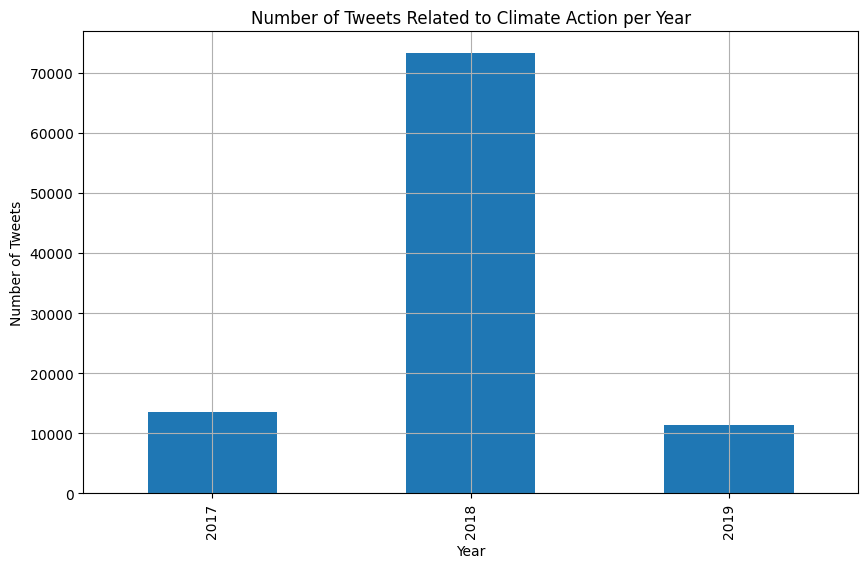

In [7]:
# Calculate the number of tweets per year
tweets_per_year = data['created_at'].value_counts().sort_index()

# Plot the number of tweets per year
plt.figure(figsize=(10, 6))
tweets_per_year.plot(kind='bar')
plt.title('Number of Tweets Related to Climate Action per Year')
plt.xlabel('Year')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.show()

In this case, I have calculated the number of tweets per year by counting the entries in the created_at column and sorting them by year. This information is visualized in the bar chart, which plots the number of tweets for each year.

The graph reveals a significant peak in the number of tweets in 2018 compared to 2017 and 2019. This spike could indicate a heightened public interest or discourse related to climate action during that year. Understanding this distribution is essential for a few reasons:

1. Contextual Insights: The peak in 2018 may correspond to specific events, campaigns, or changes in public policy that triggered increased discussions about climate action. Identifying these events can provide context to the sentiment analysis results.

2. Data Weighting: Since 2018 has a disproportionately high number of tweets, it could dominate the sentiment analysis. Recognizing this helps in deciding whether to apply any weighting or normalization techniques to balance the data across years.

3. Trend Analysis: The variation in tweet volume over the years can indicate trends in public engagement with climate-related topics. This information can be used to correlate with external factors like policy changes, environmental events, or media 
coverage.

</br>

Next, I plan to calculate the word count for each tweet by applying a function to the tokens column, which contains the tokenized words of each tweet. Then, I calculate the average word count per year by grouping the data by the created_at column and computing the mean word count for each year. 

This information is visualized in the line graph, which shows the average word count of tweets over the years.

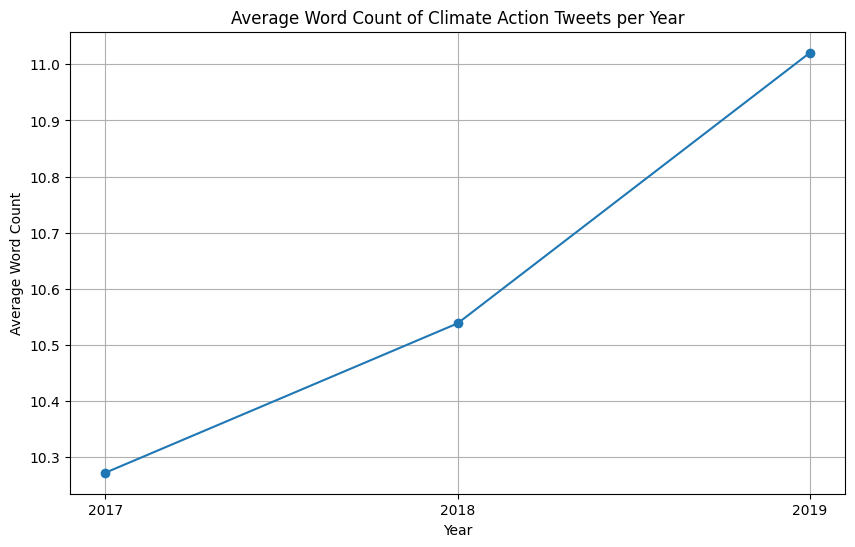

In [8]:
# Calculate the word count for each tweet
data['word_count'] = data['tokens'].apply(len)

# Calculate the average word count per year
avg_word_count_per_year = data.groupby('created_at')['word_count'].mean().reset_index()

# Plot the average word count per year
plt.figure(figsize=(10, 6))
plt.plot(avg_word_count_per_year['created_at'], avg_word_count_per_year['word_count'], marker='o')
plt.title('Average Word Count of Climate Action Tweets per Year')
plt.xlabel('Year')
plt.ylabel('Average Word Count')
plt.grid(True)

# Set x-axis ticks to be integer years
plt.xticks(avg_word_count_per_year['created_at'].astype(int))

plt.show()

The graph reveals a gradual increase in the average word count from 2017 to 2019. This trend indicates that tweets related to climate action have become slightly more verbose over time. This increase in word count could suggest that users are providing more detailed or comprehensive thoughts on climate-related topics in their tweets.

Understanding this trend is important for several reasons:
1. Firstly, it may affect the sentiment analysis, as longer tweets could provide more context and thus potentially more nuanced sentiment.

2. Secondly, it highlights the evolution in how people are discussing climate action on social media, which could be correlated with increased awareness or complexity of the discourse.

Moving forward, I can use this insight to refine my sentiment analysis approach. For instance, I might consider how the length of a tweet influences its sentiment score or whether more detailed tweets are more likely to be positive, negative, or neutral.

</br>
Or, I can consider the most common words found in tweets to potentially uncover the prevalent topics that are discussed in them:

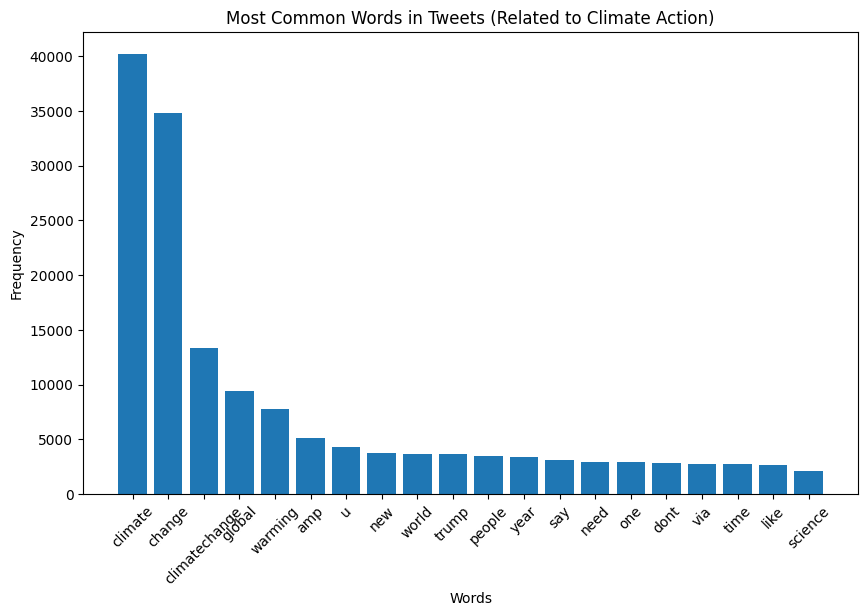

In [9]:
# Combine all tokens to find the most common words
all_tokens = [word for tokens in data['tokens'] for word in tokens]
common_words = Counter(all_tokens).most_common(20)

# Plot the most common words
words, counts = zip(*common_words)
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.title('Most Common Words in Tweets (Related to Climate Action)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

The results are visualized in the bar chart, which displays the top 20 most common words along with their frequencies.

The graph reveals that the words "climate," "change," "climatechange," "global," and "warming" are among the most frequently mentioned terms. This is expected, given the focus on climate action in the dataset. Other common words like "trump," "people," "new," and "world" suggest that discussions about climate change often intersect with broader social, political, and global contexts.

Understanding the most common words is important for several reasons:

1. Contextual Analysis: Identifying the frequent terms helps in understanding the primary topics and themes within the dataset. This contextual knowledge is crucial when interpreting sentiment analysis results.

2. Sentiment Relevance: Knowing which words are most common allows me to assess their relevance to sentiment analysis. For instance, some common words may be neutral (e.g., "year" or "new"), while others may carry more emotional weight (e.g., "trump" or "people").

</br>

Next, I want to analyze the relationship between the length of tweets and their retweet count. By understanding this relationship, I aim to uncover whether longer or shorter tweets tend to get more retweets, which can provide insights into how the length of a message might influence its spread and impact on social media.

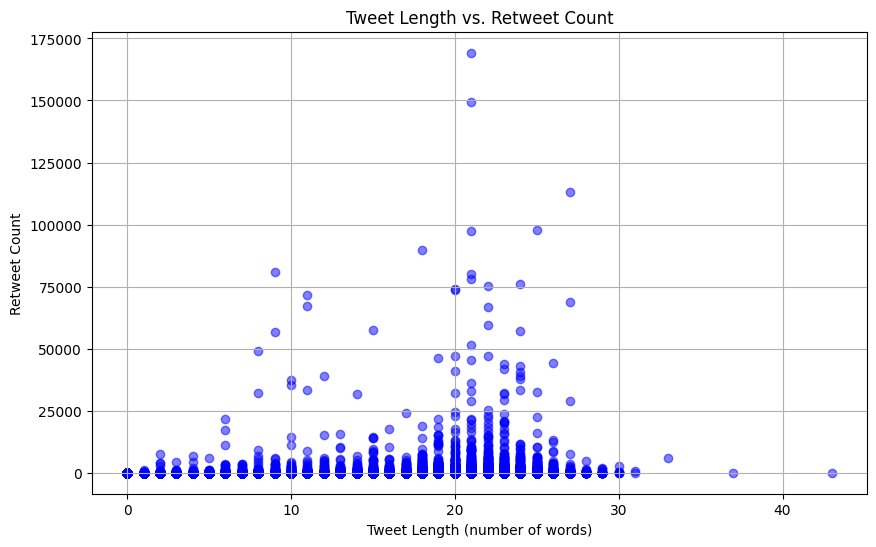

In [10]:
# Calculate tweet lengths
data['tweet_length'] = data['clean_text'].apply(lambda x: len(x.split()))

# Plot tweet length vs. retweet count
plt.figure(figsize=(10, 6))
plt.scatter(data['tweet_length'], data['retweet_count'], alpha=0.5, color='blue')
plt.title('Tweet Length vs. Retweet Count')
plt.xlabel('Tweet Length (number of words)')
plt.ylabel('Retweet Count')
plt.grid(True)
plt.show()

This plot suggests that while there is no clear linear relationship between tweet length and retweet count, tweets of moderate length (around 20 words) tend to perform reasonably well in terms of retweets. Extremely short or very long tweets are less common and do not show a consistent pattern of high retweet counts.

From this information, it is likely not beneficial to conduct further analysis focusing solely on tweet length and retweet count. The absence of a strong correlation implies that other factors, such as the content, sentiment, or context of the tweets, may play a more significant role in determining their engagement levels. Therefore, focusing on tweet length alone is unlikely to yield meaningful insights or predictive power regarding retweet counts.

Based on the visualizations and analyses so far, I now have enough information to proceed with sentiment analysis. The initial exploratory data analysis has provided insights into tweet characteristics and engagement patterns, allowing me to gain an idea of what to analyze and how to uncover trends in the data. 

With a clear understanding of the data's structure, I am now prepared to analyze the sentiment of tweets. This will help uncover trends and shifts in public opinion on climate change over time, guiding the next steps in my investigation. 

</br>

Before I do that, I will define some terms:
- A positive sentiment indicates that the tweet's author is supportive of or optimistic about initiatives and efforts to combat climate change. This could include praising new policies, acknowledging the success of environmental programs, or expressing hope about scientific advancements aimed at saving the planet. 

- A negative sentiment, on the other hand, reflects criticism or pessimism regarding climate action. Tweets with negative sentiment may highlight perceived failures, express skepticism about the effectiveness of certain measures, or convey frustration with the pace of progress. 

- A neutral sentiment implies that the tweet is informative or balanced, presenting facts or discussing climate action without a strong emotional leaning. Neutral tweets might report on events, share scientific data, or describe policies in an objective manner.

### Sentiment Analysis

In this section, I will perform sentiment analysis on the cleaned text data using the VADER sentiment analysis tool from the NLTK library. VADER is chosen for its efficiency and accuracy in analyzing social media text due to its sensitivity to both the polarity (positive/negative) and the intensity (strength) of emotions expressed in the text.

First, I will initialize the VADER sentiment analyzer, which comes pre-trained to recognize sentiment-related lexical features, including common emoticons, acronyms, and slang. This initialization allows the tool to be ready for analyzing the sentiment of the text data.

Next, I will define a function, analyze_sentiment, which will take a text input and calculate sentiment scores using VADER. These scores will include positive, negative, neutral, and compound sentiment scores. The compound score is a normalized score ranging from -1 to 1 that aggregates the overall sentiment of the text. Calculating these scores provides a detailed breakdown of the sentiment, helping to understand the different dimensions of sentiment within the text. 

To classify the overall sentiment of each tweet, I will define another function, classify_sentiment, which will categorize tweets as 'Positive', 'Negative', or 'Neutral' based on their compound score. This classification is essential for simplifying the interpretation of sentiment scores and making the results more actionable. If the compound score is greater than or equal to 0.05, the tweet will be classified as 'Positive'; if it is less than or equal to -0.05, it will be classified as 'Negative'; otherwise, it will be classified as 'Neutral'. These threshold values are chosen based on VADER's guidelines and are effective in distinguishing between positive, negative, and neutral sentiments.

In [11]:
# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to analyze sentiment
def analyze_sentiment(text):
    scores = sid.polarity_scores(text)
    return scores['pos'], scores['neg'], scores['neu'], scores['compound']

# Apply sentiment analysis to the clean text
data[['positive_score', 'negative_score', 'neutral_score', 'compound_score']] = data['clean_text'].apply(lambda x: pd.Series(analyze_sentiment(x)))

# Function to classify the overall sentiment based on compound score
def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply classification to the compound score
data['overall_sentiment'] = data['compound_score'].apply(classify_sentiment)

# Display the data with sentiment scores and overall sentiment
display(data.head(7))

,id,text,favorite_count,retweet_count,created_at,clean_text,tokens,word_count,tweet_length,positive_score,negative_score,neutral_score,compound_score,overall_sentiment
0,1028954403129184256,Gotta love the facts. https://t.co/bZ2G8AZuo9,0,0,2018,gotta love the facts,"[got, ta, love, fact]",4,4,0.583,0.000,0.417,0.6369,Positive
1,1028954356572250112,RT @ToolangiForest: A great day of action for ...,0,35,2018,toolangiforest a great day of action for our ...,"[toolangiforest, great, day, action, message, ...",15,21,0.439,0.000,0.561,0.9100,Positive
2,1028954497341480960,@jonkudelka Harvey Norman reckons climate chan...,2,0,2018,jonkudelka harvey norman reckons climate chang...,"[jonkudelka, harvey, norman, reckons, climate,...",15,21,0.000,0.000,1.000,0.0000,Neutral
3,1028954494133043200,RT @jayrosen_nyu: Why does skepticism about im...,0,52,2018,jayrosen_nyu why does skepticism about immigr...,"[jayrosen_nyu, skepticism, immigration, walk, ...",11,21,0.242,0.152,0.606,0.5267,Positive
4,1028954811511844864,RT @FranceinIreland: On 5th November we call a...,0,16,2018,franceinireland on 5th november we call all c...,"[franceinireland, 5th, november, call, creativ...",13,21,0.279,0.107,0.615,0.4939,Positive
6,1028954810781814784,You send me crap\nIt's 5 minutes to midnight f...,0,0,2018,you send me crap\nits 5 minutes to midnight fo...,"[send, crap, 5, minute, midnight, mute]",6,12,0.000,0.224,0.776,-0.3818,Negative
7,1028954742255321088,#Alaska's #NorthSlope hit by strongest #quake ...,0,0,2018,alaskas northslope hit by strongest quake note...,"[alaska, northslope, hit, strongest, quake, no...",10,16,0.231,0.000,0.769,0.4939,Positive


The updated dataset now includes columns for the sentiment scores and overall sentiment classification. For example, the sixth tweet "You send me crap It's 5 minutes to midnight for a mute" has a low positive score (0.0), a high negative and neutral score, and a very low compound score of -0.3818, resulting in an overall sentiment classification of 'Negative'. These results provide a quantitative measure of the sentiment expressed in tweets about climate action, allowing me to analyze trends and shifts in public opinion over time.

# Results, Statistical Analysis, and Visualizations

The next steps will involve visualizing the results of the sentiment analysis to gain deeper insights into public sentiment towards climate action. I will create various plots and charts to represent the distribution and trends of sentiment scores over time. 

I will begin with visualizing the distribution of overall sentiment in the dataset by creating a bar chart that displays the frequency of tweets classified as Positive, Negative, and Neutral. This bar chart was chosen for several reasons: 
- It provides a clear and straightforward overview of the overall sentiment in the dataset

- Serves as a baseline for more detailed analysis, and uses a simple yet effective format to represent categorical data

The chart helps in identifying the general sentiment landscape of the tweets related to climate action, making it easy to compare the frequencies of different sentiment categories.

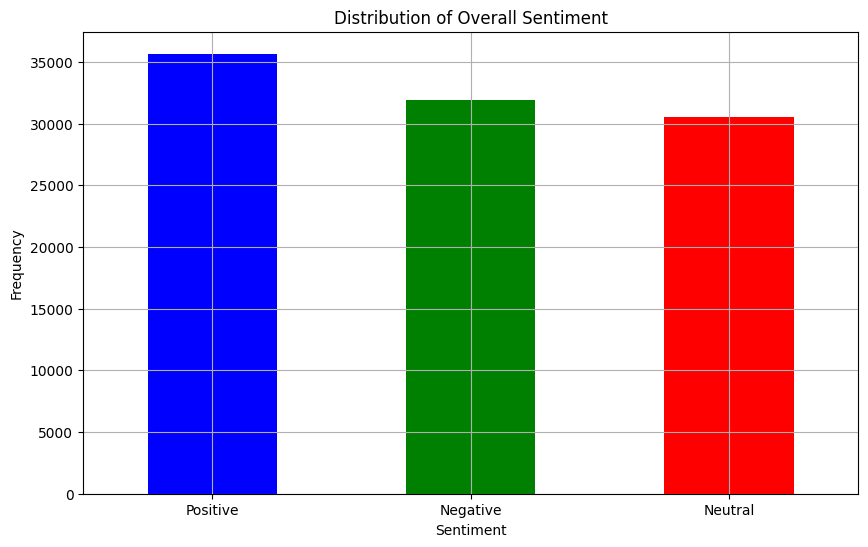

In [12]:
# Plot the distribution of overall sentiment
plt.figure(figsize=(10, 6))
data['overall_sentiment'].value_counts().plot(kind='bar', color=['blue', 'green', 'red'])
plt.title('Distribution of Overall Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

The bar chart displayed above provides a clear visualization of the overall sentiment distribution in the dataset, categorizing tweets related to climate action as Positive, Negative, or Neutral. This chart reveals several key insights into the public sentiment towards climate action as expressed on social media:

1. Positive Sentiment Dominance: The highest frequency of tweets falls into the Positive category, indicating that a significant portion of social media users express supportive or optimistic views regarding climate action. This could suggest widespread approval of climate initiatives or acknowledgment of positive steps being taken towards environmental sustainability.

2. Balanced Negative and Neutral Sentiments: The frequencies of Negative and Neutral tweets are also substantial, though slightly lower than Positive tweets. The presence of a considerable number of Negative tweets suggests that there are critical voices or concerns about climate action efforts, pointing to possible dissatisfaction or skepticism among certain groups. Meanwhile, the Neutral tweets indicate a segment of the population that discusses climate action in a more factual or balanced manner without strong emotional leanings.

However, the relatively high count of both Positive, Negative, and Neutral tweets highlights that climate action is a significant topic of discussion, engaging a broad audience on social media. This engagement can be crucial for driving public awareness and fostering collective action towards addressing climate issues.

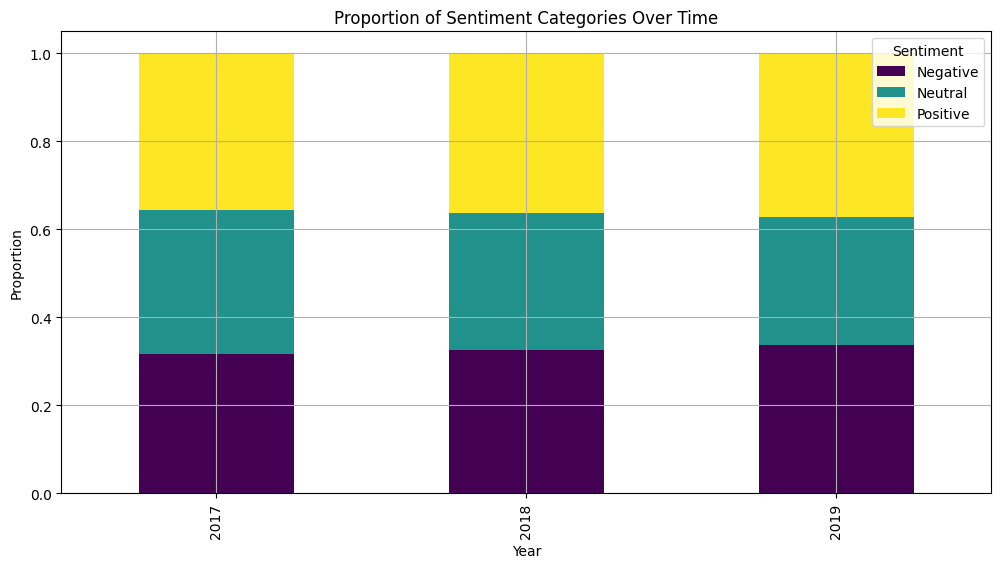

In [13]:
# Calculate the proportion of each sentiment category per year
sentiment_proportion = data.groupby(['created_at', 'overall_sentiment']).size().unstack(fill_value=0)
sentiment_proportion = sentiment_proportion.div(sentiment_proportion.sum(axis=1), axis=0)

# Plot the proportion of sentiment categories over time
sentiment_proportion.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Proportion of Sentiment Categories Over Time')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.legend(title='Sentiment')
plt.grid(True)
plt.show()

The stacked bar chart above illustrates the proportion of tweets classified as Positive, Negative, and Neutral over the years 2017, 2018, and 2019. This visualization reveals how the distribution of sentiment towards climate action has evolved over these years. 

Consistency in Sentiment Proportions: The chart shows a relatively consistent distribution of sentiment categories across the three years. Each year, Positive tweets make up the largest proportion, followed by Negative and then Neutral tweets. This consistency suggests that public sentiment towards climate action has remained relatively stable over this period, with a predominant inclination towards positive discussions.

I was quite surprised to see that, despite the significant scientific breakthroughs and increasing urgency to save the planet, the positive sentiment of the public has not shown a substantial increase over the years, as evidenced by the consistent proportions in the graph.

Stable Neutral and Negative Sentiments: The persistent proportion of Neutral tweets suggests that a considerable segment of the public continues to discuss climate action in an informative or balanced manner, without strong emotional leanings. This reflects an ongoing engagement with factual or objective discourse. Similarly, the stable proportion of Negative tweets indicates that critical perspectives and dissatisfaction with climate initiatives remain a constant part of the conversation. This stability in Neutral and Negative sentiments implies that while public support for climate action is strong, there are enduring concerns and a consistent demand for more effective solutions and transparency in addressing climate change.


</br>
Another way to observe the trends in sentiments toward climate action is to see what type of tweets gain the most traction in the public. The scatter plot above shows the relationship between the compound sentiment score of tweets and their retweet count:

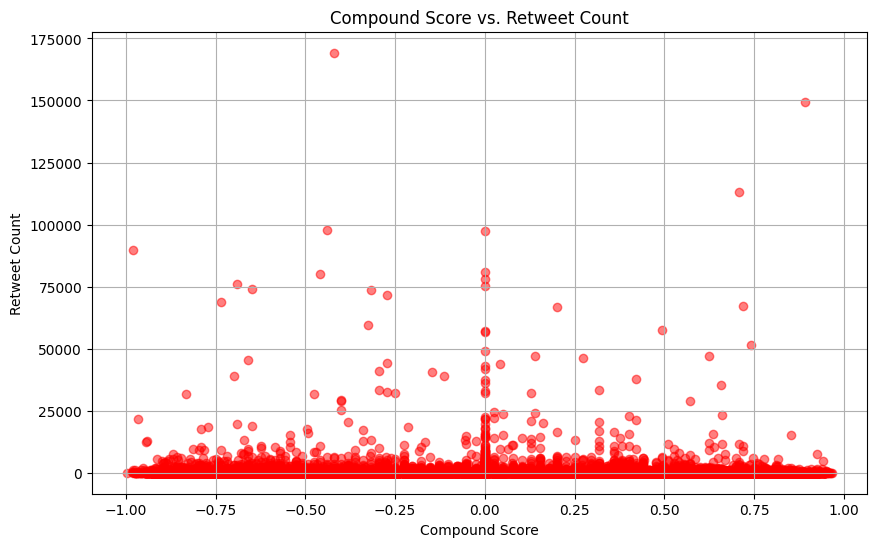

In [14]:
# Scatter plot of compound score vs. retweet count
plt.figure(figsize=(10, 6))
plt.scatter(data['compound_score'], data['retweet_count'], alpha=0.5, color='red')
plt.title('Compound Score vs. Retweet Count')
plt.xlabel('Compound Score')
plt.ylabel('Retweet Count')
plt.grid(True)
plt.show()

From the plot, it is evident that there is no strong linear correlation between sentiment and retweet count, as tweets with various sentiment scores (ranging from highly negative to highly positive) can receive high retweet counts. However, it can be observed that tweets with neutral or slightly positive sentiments tend to have a higher density of retweets in the lower to middle ranges, suggesting that neutral or moderately positive content might be more widely accepted and shared.

Interestingly, some tweets with extreme sentiment scores (both positive and negative) also achieve high retweet counts, indicating that strongly opinionated tweets, regardless of whether they are positive or negative, can resonate deeply with certain audiences and provoke significant engagement. This could reflect the polarizing nature of climate action discussions, where strong opinions (either for or against) can generate considerable public interaction.

</br>
While I am on the topic of climate actions discussions in the public, a retweet network graph is a powerful tool for understanding the dynamics of information dissemination and influence on social media, particularly in the context of climate action. By visualizing the connections between users based on retweet relationships, we can identify key influencers, understand how information spreads, and uncover the structure of the conversation around climate change.

In [15]:
# Extract retweet relationships
def extract_retweet_user(text):
    match = re.findall(r'RT @(\w+):', text)
    return match[0] if match else None

def extract_original_user(text):
    match = re.findall(r'@(\w+)', text)
    return match[0] if match else None

data['retweet_user'] = data['text'].apply(extract_retweet_user)
data['original_user'] = data['text'].apply(extract_original_user)

# Drop rows without retweet information
retweet_data = data.dropna(subset=['retweet_user'])

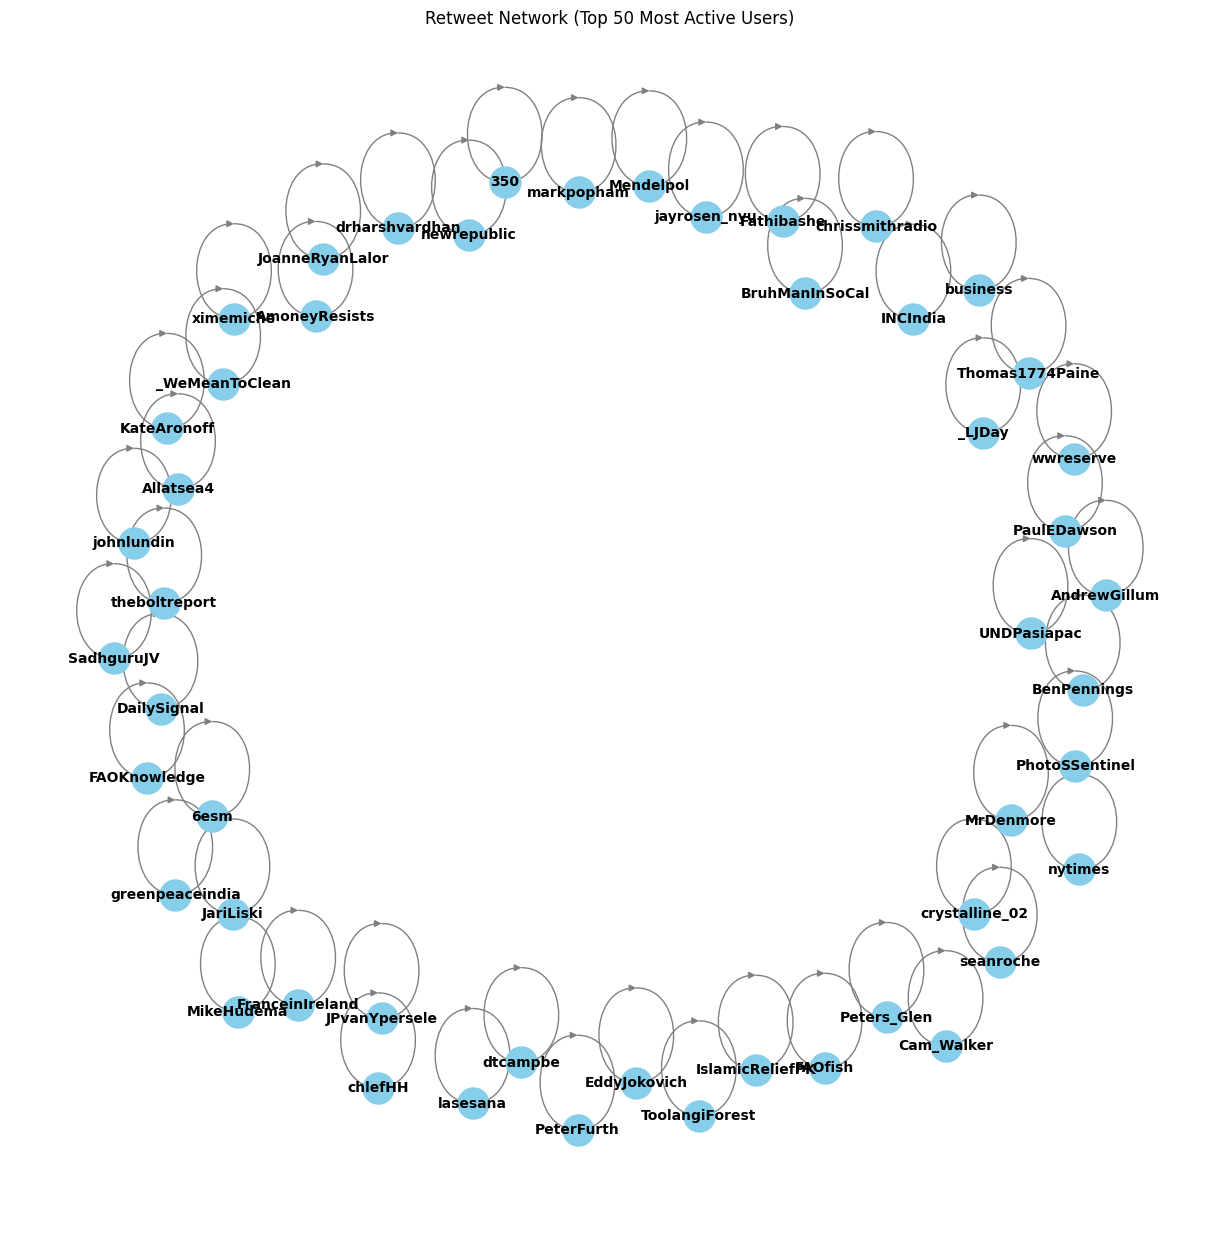

In [16]:
# Extract retweet relationships
def extract_retweet_user(text):
    match = re.findall(r'RT @(\w+):', text)
    return match[0] if match else None

def extract_original_user(text):
    match = re.findall(r'@(\w+)', text)
    return match[0] if match else None

# Assuming 'data' is your dataframe
data['retweet_user'] = data['text'].apply(extract_retweet_user)
data['original_user'] = data['text'].apply(extract_original_user)

# Drop rows without retweet information
retweet_data = data.dropna(subset=['retweet_user'])

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for index, row in retweet_data.iterrows():
    G.add_edge(row['retweet_user'], row['original_user'])

# Focus on the most active users by degree centrality
degree_dict = dict(G.degree(G.nodes()))
most_active_users = sorted(degree_dict, key=degree_dict.get, reverse=True)[:50]

# Create a subgraph with the most active users
G_sub = G.subgraph(most_active_users)

# Draw the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_sub, k=0.3)
nx.draw(G_sub, pos, with_labels=True, node_size=500, node_color='skyblue', edge_color='gray', font_size=10, font_color='black', font_weight='bold')
plt.title('Retweet Network (Top 50 Most Active Users)')
plt.show()

The graph illustrates the retweet network among the top 50 most active users, based on their degree centrality. Each node represents a user, and each directed edge represents a retweet relationship from one user to another. The size of the nodes is proportional to their degree centrality, indicating how many connections (both incoming and outgoing) a user has. Users with more connections are more central in the network, suggesting they have a higher influence in spreading information.

The retweet network reveals that there are no overly networked individuals; instead, most users have a similar number of retweets, indicating a uniform distribution of engagement. This suggests that the climate action discussion on Twitter is supported by a broad base of active participants rather than being dominated by a few key influencers. The tightness of the network, with closely connected nodes and numerous retweet relationships, signifies active engagement and widespread dissemination of climate action messages. This cohesive structure points to a highly mobilized and engaged community that effectively spreads information, raises awareness, and drives collective action towards climate advocacy (regardless of whether the advocacy is positive or negative). 

The uniform retweet activity and strong community dynamics underscore the potential for significant impact as messages are rapidly and efficiently shared within this resilient network.

</br>
Based on the sentiment analysis of tweets from past years, I've gained valuable insights into the public's evolving opinions on climate action. It seems that public sentiment has remained relatively stable with a slight more positive course of action towards saving the environemnt, despite some consistent critical voices and neutral discussions.

To build on this understanding, it is crucial to anticipate future sentiment trends. Predicting what the sentiment will be in the coming years allows us to prepare for potential changes in public opinion and to tailor our communication and engagement strategies accordingly. 

By leveraging linear regression, I try to forecast the average compound sentiment scores for the next several years, providing a forward-looking perspective on public sentiment towards climate action.

In [17]:
# Calculate the average compound sentiment score per year
avg_sentiment_per_year = data.groupby('created_at')['compound_score'].mean().reset_index()

# Rename columns for clarity
avg_sentiment_per_year.columns = ['year', 'average_compound_score']

# Display the data
display(avg_sentiment_per_year)

# Prepare the data for linear regression
X = avg_sentiment_per_year['year'].values.reshape(-1, 1)
y = avg_sentiment_per_year['average_compound_score'].values

,year,average_compound_score
0,2017,0.007822
1,2018,0.012201
2,2019,0.009578


In [18]:
# Initialize the linear regression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Predict the sentiment scores for the existing data
y_pred = model.predict(X)
# Calculate the MSE
mse = mean_squared_error(y, y_pred)

# Print the MSE
print("Mean Squared Error (MSE) of the training data:", mse)

Mean Squared Error (MSE) of the training data: 2.723203466214143e-06


,year,predicted_compound_score
0,2020,0.011622
1,2021,0.012500
2,2022,0.013378
3,2023,0.014256
4,2024,0.015133
5,2025,0.016011
6,2026,0.016889


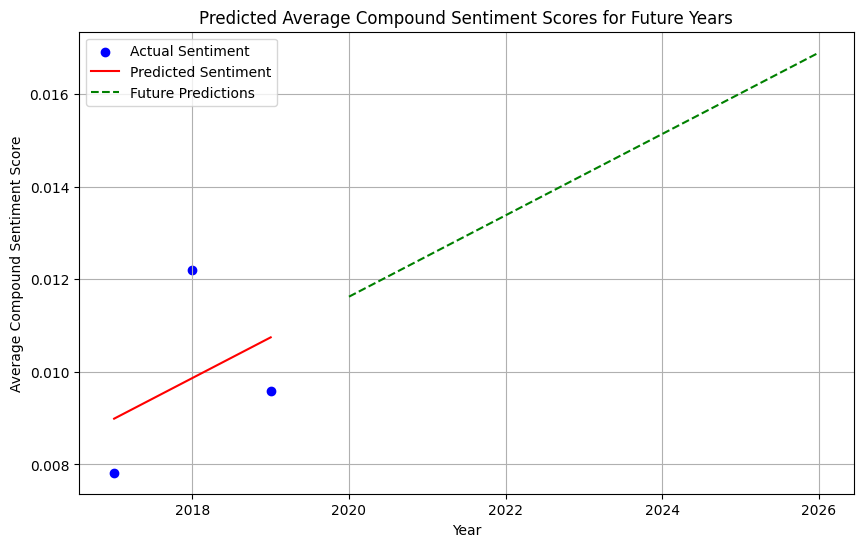

In [19]:
# Define future years
future_years = np.array([2020, 2021, 2022, 2023, 2024, 2025, 2026]).reshape(-1, 1)

# Predict future sentiment scores
future_sentiment_scores = model.predict(future_years)

# Display the predicted sentiment scores
future_predictions = pd.DataFrame({'year': future_years.flatten(), 'predicted_compound_score': future_sentiment_scores})
display(future_predictions)

# Plot the predicted future sentiment scores
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Actual Sentiment')
plt.plot(X, y_pred, color='red', label='Predicted Sentiment')
plt.plot(future_years, future_sentiment_scores, color='green', linestyle='dashed', label='Future Predictions')
plt.title('Predicted Average Compound Sentiment Scores for Future Years')
plt.xlabel('Year')
plt.ylabel('Average Compound Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()

The graph above illustrates the forecast of the average compound sentiment scores over time, using a linear regression model. The blue line represents the predicted average compound scores from the present year up to 2026, while the red dots indicate the actual average compound scores from past years. The linear regression model predicts a gradual increase in the average compound sentiment scores over the next few years, and all scores being positive. This suggests that public sentiment towards climate action is only expected to become more positive. Although the actual data points show some variation around the trend line, indicating yearly fluctuations, the overall upward trend suggests a more optimistic outlook for future sentiment.

This predicted increase in positive sentiment is encouraging for climate action advocates, as it indicates growing public support for climate initiatives. Policymakers and activists can use this information to plan their strategies more effectively, leveraging the anticipated increase in positive sentiment to introduce more ambitious climate policies and initiatives. While the forecast is optimistic, it remains crucial to continue monitoring sentiment trends to ensure that this positive trajectory is maintained. By understanding and anticipating these trends, climate advocates can push forward with confidence, knowing that public sentiment is likely to favor their efforts in the coming years.

# Discussion

The analysis of public sentiment towards climate action using social media data reveals several key insights into how opinions have evolved over time and what we can expect in the future. Through comprehensive sentiment analysis, the study has shown a generally positive sentiment towards climate action, with a slightly greater proportion of tweets expressing support or optimism. This positive sentiment has remained relatively stable over the years, despite some yearly fluctuations, indicating consistent public engagement with climate-related topics.

The distribution of sentiments over time highlights a predominant inclination towards positive discussions, with a slightly less representation of negative and neutral sentiments. This suggests that while there is strong support for climate action, there are also persistent concerns and critical voices that reflect the complexity of the issue. The presence of neutral tweets indicates an ongoing engagement with factual and balanced discourse, which is essential for informed decision-making.

Forecasting future sentiment trends using linear regression indicates a gradual increase in positive sentiment towards climate action over the next few years. This optimistic outlook suggests growing public support for climate initiatives, which is encouraging for policymakers and activists. Leveraging this anticipated positive trajectory, stakeholders can introduce more ambitious policies and initiatives, knowing that public sentiment is likely to favor their efforts.

Overall, these insights not only highlight the robust and growing support for saving the world but also empower policymakers and activists with the foresight to harness this momentum, paving the way for transformative environmental progress and a more sustainable future.